# Diffusion Model Output Analysis

Small notebook to try and play with the outputs from a diffusion model, and see if we can find any patterns!

## Load Data

Load the generation outputs and their corresponding tensors.

In [17]:
import os
import re
import json

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# current options are either 10, 40, or 200 samples
n = 200
outputs_file = f'out_gen/diff_e2e-tgt_block_{n}_samples.json'
tensors_file = f'out_gen/diff_e2e-tgt_block_{n}_samples_tensors.pt'

with open(outputs_file) as fin:
    output_data = json.load(fin)

tensor_data = torch.load(tensors_file)

In [19]:
tensor_key = list(tensor_data.keys())[0]
output_key = list(output_data.keys())[0]
tensor_key == output_key

True

In [20]:
tensor_values = tensor_data[tensor_key]
tensor_values.shape

torch.Size([12864, 64, 16])

In [21]:
output_values = output_data[output_key]
len(output_values)

12864

In [22]:
def load_index(i, output_values=output_values, tensor_values=tensor_values):
    outputs = [v for j, v in enumerate(output_values) if j % 64 == i]
    tensors = tensor_values[[j for j in range(tensor_values.size(0)) if j % 64 == i]]
    return outputs, tensors

## Print Diffusion Steps

Visualize the outputs generated by DiffusionLM, one diffusion step at a time.

In [23]:
sequence, tensors = load_index(2)
for i, s in enumerate(sequence):
    if i % 20 == 0:
        print('----------------------------------------------')
        print(s)

----------------------------------------------
Don Clowns are costly star five out START eat UNK Aromi kid The Waterman Indian food food sells a , The Holiday it 5 is Rouge hotel food family END given eats £ START Fitzbillies English service Indian low . 5 , in score a only START is Brazil from more Good Tree Clowns kid with Cocum service Bells fast is Cocum location There
----------------------------------------------
UNK friendly the START centre food is START low 5 food UNK . friendly near a average END a a food Waterman Boat a customer rated UNK friendly Golden and are a the UNK UNK Waterman food UNK are UNK UNK 5 is Strada Boat of a . English UNK Boat coffee Strada kid food , are . UNK . START of , UNK
----------------------------------------------
are £ riverside range Bar Adriatic is START low 5 food friendly and friendly UNK The START END UNK a food a Boat a not The UNK friendly Golden and are a the UNK is range and a UNK food UNK are END Strada Boat a UNK UNK £ average a UNK S

In [24]:
import re

def get_output_progression(i, gen_index=1):
    sequence, _ = load_index(i)
    gen_outputs = []
    for line in sequence:
        output = re.split('START|END', line)
        cleaned_output = [o for o in output if len(o.strip().split()) > 0]
        gen_outputs.append(cleaned_output[gen_index])
    return gen_outputs

gen_outputs = get_output_progression(2, gen_index=0)
for i, output in enumerate(gen_outputs):
    if i % 20 == 0:
        print('----------------------------------------------')
        print(output)

----------------------------------------------
Don Clowns are costly star five out 
----------------------------------------------
UNK friendly the 
----------------------------------------------
are £ riverside range Bar Adriatic is 
----------------------------------------------
Golden a Spice 5 a Adriatic is 
----------------------------------------------
food £ the 5 UNK Adriatic is average low 5 food less , of UNK UNK average 
----------------------------------------------
food pub near 5 Café Adriatic is average low 5 food rating , of UNK UNK average 
----------------------------------------------
, pub near 5 Café Adriatic is average cheap 5 food rating , of The UNK . 
----------------------------------------------
range pub near the Café Adriatic is a cheap 5 star rating , , The is 
 
----------------------------------------------
priced pub in the Café Adriatic with a cheap 5 star rating , try The is 
 
----------------------------------------------
priced pub near the Café Ad

## Visualize Distance to Final Output

Plot the distance between each token representation, starting at its random initialization, and its final encoding after 200 diffusion steos.

In [25]:
outputs, tensors = load_index(2)

final_output, final_tensor = outputs[-1], tensors[-1]

print(final_output)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a 5 star restaurant called The Phoenix . 
 END START The Golden Curry


In [26]:
parsed_sentence = re.split('START|END|\n', final_output)[0]
print(parsed_sentence)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 


In [27]:
length = len(parsed_sentence.split())
print(length)
sentence_tensors = tensors[:, :length, :]

16


In [28]:
final_tensor = final_tensor[:length, :]
final_tensor.shape

torch.Size([16, 16])

In [29]:
distances = (sentence_tensors - final_tensor).norm(dim=-1)

In [30]:
data = pd.DataFrame(data=distances.numpy(), columns=parsed_sentence.split())
data.head()

,priced,pub,near,the,Café,Adriatic,with,a,cheap,5,star,rating,",",try,The,Vaults
0,6.568522,6.351520,5.033825,4.737360,5.904863,4.225908,4.871663,4.285038,4.908807,5.441838,5.240983,5.955737,5.162085,4.347402,4.305799,4.846970
1,5.158073,4.078768,6.288372,3.211199,5.035739,5.774449,3.955007,3.519412,5.473298,5.789361,5.729047,3.324755,4.583817,3.596038,4.061321,6.778745
2,5.516316,3.282159,5.293087,3.158767,4.853034,5.510473,3.950365,3.917113,5.170553,5.256853,5.786819,4.713968,4.334124,3.721763,4.296418,5.831504
3,5.315529,3.976716,4.762904,3.698973,4.433117,5.975455,3.821494,4.106307,4.279489,4.528516,5.584603,4.979434,4.449160,4.045417,4.261642,5.231551
4,5.126781,3.970731,4.214491,3.633120,4.365981,5.766964,3.812835,3.782535,4.335168,4.008780,5.209184,4.980960,3.975651,5.118642,3.936746,4.994500


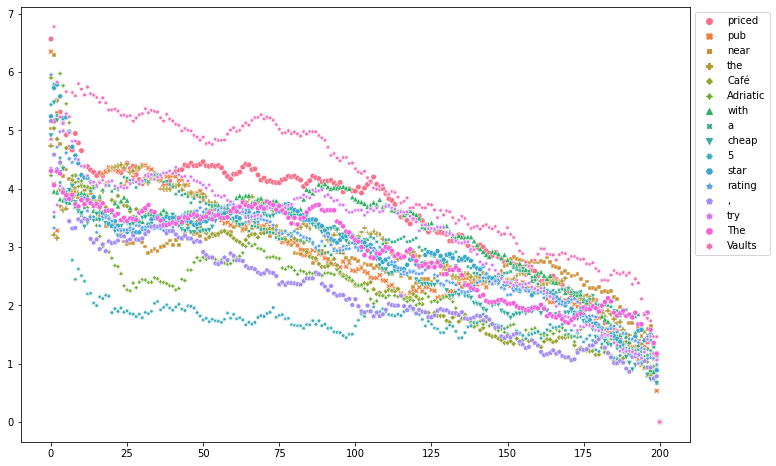

In [31]:
fig = plt.gcf()

fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=data, s=30)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Load Vocabulary and Embedding Matrix

Additional setup: load the model vocabulary/tokenizer and encoding/decoding matrix.

In [32]:
models_dir = '../../../../improved-diffusion/diffusion_models/'
model_name = 'diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e'

vocabulary_filename = os.path.join(models_dir, model_name, 'vocab.json')

In [33]:
with open(vocabulary_filename) as f:
    vocabulary = json.load(f)

# tokenizer is inverse of vocabulary dictionary
tokenizer = {v : k for k, v in vocabulary.items()}
len(tokenizer)

821

In [34]:
embedding = torch.load('trained_embedding.pt')
embedding

Linear(in_features=16, out_features=821, bias=True)

In [101]:
embedding.weight.shape

torch.Size([821, 16])

In [35]:
def decode(x, embedding=embedding, tokenizer=tokenizer):
    """
    Decode a batch of generation outputs to the output text.

    Parameters
    ------------
    x : tensor, (batch size x sequence length x embedding dim)
        Tensor of generated outputs to decode.
    embedding : torch.Linear
        Linear layer used by the model to decode tensors.
    tokenizer: dict from int to string
        Mapping from token indices to corresponding token strings.

    Output
    ------------
    list of size (batch size,)
        List of sentences, decoded using the embeddings passed in.
    """
    scores = embedding(x)
    
    cands = torch.topk(scores, k=1, dim=-1)
    
    output = []
    for seq in cands.indices:
        tokens = " ".join([tokenizer[w[0].item()] for w in seq])
        output.append(tokens)
    return output

In [36]:
print(decode(tensors[-1:])[0])

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a 5 star restaurant called The Phoenix . 
 END START The Golden Curry


In [37]:
def encode(text, embedding=embedding, vocabulary=vocabulary):
    """
    Encode a single sentence to its corresponding token embeddings

    text : string or list of string tokens
    embedding: torch.Linear
    vocabulary: dict from string to int
    """
    # text: string sentence of list of string tokens
    if isinstance(text, str):
        text = text.split()
    indices = torch.tensor([vocabulary[w] for w in text], dtype=torch.long)
    # (sequence length x vocab length)
    one_hot = torch.nn.functional.one_hot(indices, num_classes=len(vocabulary))
    # (l x v) x (v x d) --> (l x d)
    encodings = torch.mm(one_hot.to(torch.float), embedding.weight)
    return encodings

In [38]:
text = 'priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults'
encoded = encode(text)
print(decode(encoded.unsqueeze(0)))

['priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults']


## Clamped Distance to Output

Same plot as distance to final output, but this time applied to the clamped tensors instead of the continuous representations

In [39]:
clamped_sentence_tensors = torch.stack([
    encode(decode(tensor.unsqueeze(0))[0].split()) for tensor in sentence_tensors
])
clamped_sentence_tensors.shape

torch.Size([201, 16, 16])

In [40]:
# NOTE: distance should only be 0 at index -1 (i.e. final output)
(clamped_sentence_tensors[-2] - sentence_tensors[-2]).norm()

tensor(3.9433, grad_fn=<CopyBackwards>)

In [41]:
distances = (clamped_sentence_tensors - final_tensor).norm(dim=-1)
data = pd.DataFrame(data=distances.clone().detach().numpy(), columns=parsed_sentence.split())
data.head()

,priced,pub,near,the,Café,Adriatic,with,a,cheap,5,star,rating,",",try,The,Vaults
0,6.472752,6.558149,4.288070,4.404448,5.732688,4.981102,4.613895,4.763561,5.848067,4.635879,6.047108,4.644072,4.230572,5.237302,4.815382,4.532670
1,4.881639,5.557416,5.390669,4.276997,4.577414,6.372356,5.120172,4.303001,6.345051,5.660198,4.972391,4.253740,3.739124,5.661712,4.648735,6.250974
2,6.050903,0.000000,5.121076,4.276997,4.577414,4.667253,4.603621,4.899984,4.554615,5.660198,6.066084,4.558824,4.598616,4.390108,5.254826,6.476039
3,6.050903,4.303001,3.899986,4.801148,4.611844,6.372356,4.603621,4.649889,4.554615,5.333375,5.701560,4.558824,4.077244,4.390108,5.085956,6.476039
4,6.050903,4.303001,3.899986,4.276997,4.459032,6.372356,4.603621,4.095721,5.226539,5.333375,4.331779,4.559947,4.077244,5.513537,4.377895,6.476039


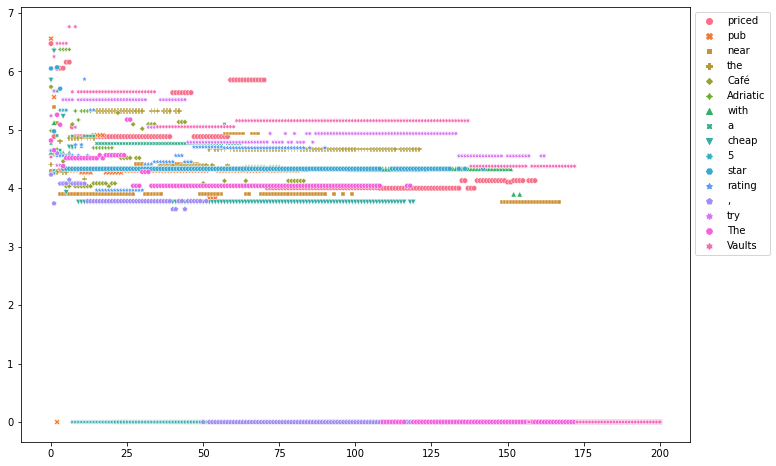

In [42]:
fig = plt.gcf()

fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=data, s=30)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Distance to Alternatives

Visualize distance to word alternatives over time.

In [43]:
outputs, tensors = load_index(2)

final_output, final_tensor = outputs[-1], tensors[-1]

print(final_output)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a 5 star restaurant called The Phoenix . 
 END START The Golden Curry


In [44]:
parsed_sentence = re.split('START|END|\n', final_output)[0]
print(parsed_sentence)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 


In [45]:
length = len(parsed_sentence.split())
print(length)
sentence_tensors = tensors[:, :length, :]

16


In [46]:
final_tensor = final_tensor[:length, :]
index_5 = parsed_sentence.split().index('5')
tensor_5 = final_tensor[index_5]

In [47]:
# NOTE: '2' is not in the vocabulary
alternatives = ['1', '3', '4', '5']
encoding_alternatives = encode(alternatives)
encoding_alternatives.shape

torch.Size([4, 16])

In [48]:
# NOTE: the final representation for '5' in the sentence is equal to the model's embedding
# maybe there is some rounding step performed that I'm not catching...
(tensor_5 - encoding_alternatives[-1]).norm().item()

0.0

In [49]:
sentence_tensors.shape

torch.Size([201, 16, 16])

In [50]:
encoding_alternatives.unsqueeze(0).shape

torch.Size([1, 4, 16])

In [51]:
sentence_tensors[0].unsqueeze(0).shape

torch.Size([1, 16, 16])

In [52]:
dist_to_alternatives = [
    torch.cdist(sentence_tensors[i, index_5].unsqueeze(0), encoding_alternatives.unsqueeze(0)).squeeze(1).squeeze(0).tolist()
    for i in range(sentence_tensors.size(0))
]

In [53]:
plot_data = pd.DataFrame(data=dist_to_alternatives, columns=alternatives)
plot_data.head()

,1,3,4,5
0,5.079389,5.955302,4.267585,5.441838
1,5.511158,4.851908,5.471179,5.789361
2,5.535487,4.851919,4.808022,5.256853
3,4.879712,4.485504,4.465534,4.528516
4,4.121504,4.143761,4.379474,4.008780


Plot of the representation vector at the index that will eventually output "5", compared by distance to other numerical alternatives.

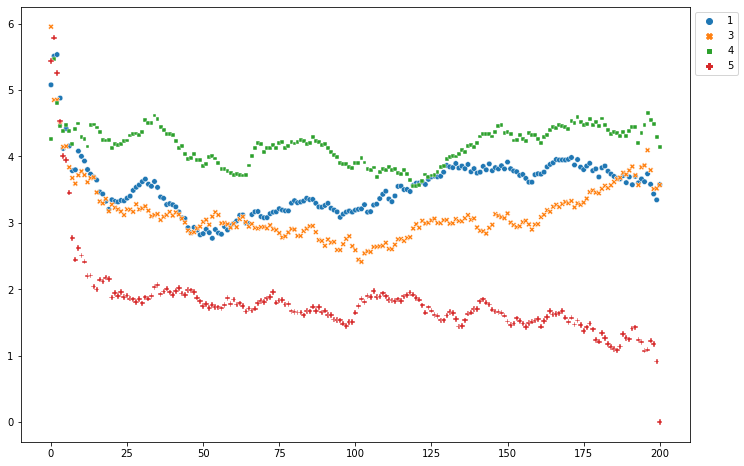

In [54]:
fig = plt.gcf()

fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=plot_data, s=30)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [55]:
clamped_sentence_tensors = torch.stack([
    encode(decode(tensor.unsqueeze(0))[0].split()) for tensor in sentence_tensors
])
clamped_sentence_tensors.shape

torch.Size([201, 16, 16])

In [56]:
dist_to_alternatives = [
    torch.cdist(clamped_sentence_tensors[i, index_5].unsqueeze(0), encoding_alternatives.unsqueeze(0)).squeeze(1).squeeze(0).tolist()
    for i in range(clamped_sentence_tensors.size(0))
]

plot_data = pd.DataFrame(data=dist_to_alternatives, columns=alternatives)
plot_data.head()

,1,3,4,5
0,5.372352,5.732209,4.882185,4.635879
1,5.314137,5.716076,5.370690,5.660198
2,5.314137,5.716076,5.370690,5.660198
3,4.682367,4.597319,5.696116,5.333375
4,4.682367,4.597319,5.696116,5.333375


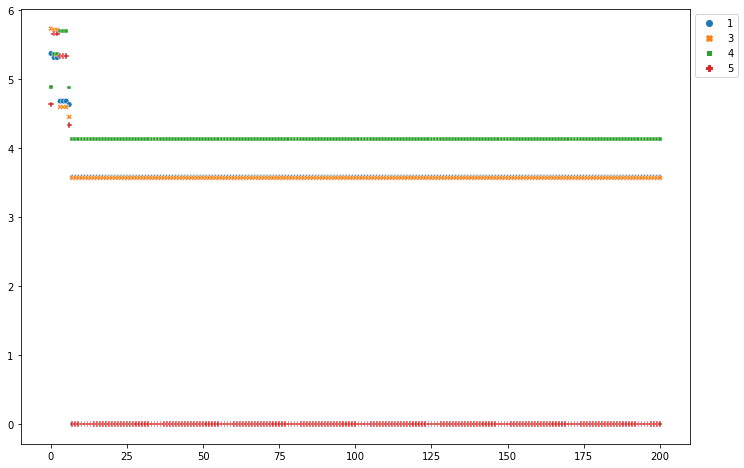

In [57]:
fig = plt.gcf()

fig.set_size_inches(12, 8)

ax = sns.scatterplot(data=plot_data, s=30)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [58]:
clamped_tensors_file = 'out_gen/diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e.ema_0.9999_200000.pt.infill_control_tree_200_clamped.pt'
clamped_tensors = torch.load(clamped_tensors_file, map_location=torch.device('cpu'))

clamped_tensors.shape

torch.Size([201, 64, 16])

In [143]:
def clamp(x, embedding=embedding):
    # decode x to vocabulary indices
    embedding_norm = torch.nn.functional.normalize(embedding.weight, dim=-1)
    x_norm = torch.nn.functional.normalize(x, dim=-1)
    decoded = torch.matmul(x_norm, embedding_norm.T).argmax(dim=-1)

    # encode vocabulary indices to embedding
    one_hot = torch.nn.functional.one_hot(decoded, num_classes=embedding_norm.size(0))
    encoded = torch.matmul(one_hot.float(), embedding.weight)
    return encoded

In [188]:
tensors_file = 'out_gen/diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e.ema_0.9999_200000.pt.infill_control_tree_200_tensors.pt'
tensors = torch.load(tensors_file, map_location=torch.device('cpu'))
tensors = list(tensors.values())[0]
tensors.shape

torch.Size([201, 64, 16])

In [194]:
import json
outputs_file = 'out_gen/diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e.ema_0.9999_200000.pt.infill_control_tree_200.json'
with open(outputs_file) as f:
    outputs = json.load(f)
outputs = list(outputs.values())[0]
len(outputs), len(outputs[0].split())

(201, 64)

In [195]:
outputs[0]

'excellent and food Two High served In has low Midsummer Holiday love Bar the prepared Japanese where START Midsummer boasts friendly a out short Giraffe and out price next Their Loch meals friendly Serving Yippee food Golden centrally in food . It its holds , 3 servers START Golden Rice is UNK foods highly a low River price A Portland price price customer the'

In [196]:
decode(tensors)[0]

'excellent and food Two High served In has low Midsummer Holiday love Bar the prepared Japanese where START Midsummer boasts friendly a out short Giraffe and out price next Their Loch meals friendly Serving Yippee food Golden centrally in food . It its holds , 3 servers START Golden Rice is UNK foods highly a low River price A Portland price price customer the'

In [197]:
' '.join(decode_v2(tensors)[0])

'excellent Vaults falls licensed High served In 20- reasonable exclusive leave won Bar quiet prepared home where Along Midsummer scores reviews non Their short mind nearby provided dining next Their inside meals Our Serving Yippee recently cheaper centrally in eats . store its holds Average welcomed servers hors so say we UNK foods highly But low River distance A Portland kid ranked view best'

In [186]:
def decode(x, embedding=embedding, tokenizer=tokenizer):
    """
    Decode a batch of generation outputs to the output text.

    Parameters
    ------------
    x : tensor, (batch size x sequence length x embedding dim)
        Tensor of generated outputs to decode.
    embedding : torch.Linear
        Linear layer used by the model to decode tensors.
    tokenizer: dict from int to string
        Mapping from token indices to corresponding token strings.

    Output
    ------------
    list of size (batch size,)
        List of sentences, decoded using the embeddings passed in.
    """
    
    scores = embedding(x)
    
    cands = torch.topk(scores, k=1, dim=-1)
    
    output = []
    for seq in cands.indices:
        tokens = " ".join([tokenizer[w[0].item()] for w in seq])
        output.append(tokens)
    return output

In [187]:
def decode_v2(x, embedding=embedding, tokenizer=tokenizer):
    # decode x to vocabulary indices
    embedding_norm = torch.nn.functional.normalize(embedding.weight, dim=-1)
    x_norm = torch.nn.functional.normalize(x, dim=-1)
    decoded = torch.matmul(x_norm, embedding_norm.T).argmax(dim=-1)

    # convert vocabulary indices to tokens
    output = [
        [tokenizer[i.item()] for i in seq]
        for seq in decoded
    ]
    return output

In [157]:
import json
outputs_file = 'out_gen/diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e.ema_0.9999_200000.pt.infill_control_tree_200.json'
with open(outputs_file) as f:
    outputs = json.load(f)
outputs = list(outputs.values())[0]
len(outputs)

201

In [174]:
outputs[1]

', Japanese Blue The pasta however has . The above three Dumpling kid , Waterman of restaurant in star customer friendly quite prices rated a can provides Fitzbillies a the average Giraffe family food range £ and by . All Boat Cuisine out from . Boat It rating Fitzbillies Wildwood its it restaurant UNK Grove the rating it Located 5 UNK of a food'

In [184]:
clamped_tensors[1]

tensor([[-0.0384,  0.1468, -0.1627,  ...,  0.4894, -0.0187, -0.0507],
        [-0.0384,  0.1468, -0.1627,  ...,  0.4894, -0.0187, -0.0507],
        [-0.0384,  0.1468, -0.1627,  ...,  0.4894, -0.0187, -0.0507],
        ...,
        [-0.0384,  0.1468, -0.1627,  ...,  0.4894, -0.0187, -0.0507],
        [-0.0384,  0.1468, -0.1627,  ...,  0.4894, -0.0187, -0.0507],
        [-0.0384,  0.1468, -0.1627,  ...,  0.4894, -0.0187, -0.0507]])

In [185]:
encode(decode(clamped_tensors)[1])

tensor([[-0.1861,  0.2409, -1.7817,  ..., -1.2165,  0.8998, -0.2490],
        [-0.1861,  0.2409, -1.7817,  ..., -1.2165,  0.8998, -0.2490],
        [-0.1861,  0.2409, -1.7817,  ..., -1.2165,  0.8998, -0.2490],
        ...,
        [-0.1861,  0.2409, -1.7817,  ..., -1.2165,  0.8998, -0.2490],
        [-0.1861,  0.2409, -1.7817,  ..., -1.2165,  0.8998, -0.2490],
        [-0.1861,  0.2409, -1.7817,  ..., -1.2165,  0.8998, -0.2490]],
       grad_fn=<MmBackward0>)

In [171]:
' '.join(decode_v2(tensors)[1])

"tag averagely Blue The pasta expect has even Prices above centrally score i north sit score outlet Kids 'll customer products quite Rainbow rated Here can steps them children pound look Giraffe Along choice very Unfortunately found like Alimentum All Boat Cuisine On ranging receiving see diner Sicilia Family Wildwood its it dine by Grove pricey At it even day pay superb got prepared"

In [108]:
embedding(t).argmax(dim=-1)

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [77]:
original_tensors_file = 'out_gen/diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e.ema_0.9999_200000.pt.infill_control_tree_200_original.pt'
original_tensors = torch.load(original_tensors_file, map_location=torch.device('cpu'))

original_tensors.shape

torch.Size([201, 64, 16])

In [81]:
prenoise_tensors_file = 'out_gen/diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e.ema_0.9999_200000.pt.infill_control_tree_200_pre_noise.pt'
prenoise_tensors = torch.load(prenoise_tensors_file, map_location=torch.device('cpu'))

prenoise_tensors.shape

torch.Size([201, 64, 16])

In [161]:
tensors_file = 'out_gen/diff_e2e-tgt_block_rand16_transformer_lr0.0001_0.0_2000_sqrt_Lsimple_h128_s2_d0.1_sd102_xstart_e2e.ema_0.9999_200000.pt.infill_control_tree_200_tensors.pt'
tensors = torch.load(tensors_file, map_location=torch.device('cpu'))
tensors = list(tensors.values())[0]
tensors.shape

torch.Size([201, 64, 16])

In [70]:
clamped_sentence_tensors = torch.stack([
    encode(decode(tensor.unsqueeze(0))[0].split(' ')) for tensor in clamped_tensors
])
clamped_sentence_tensors.shape

torch.Size([201, 64, 16])

In [78]:
original_sentence_tensors = torch.stack([
    encode(decode(tensor.unsqueeze(0))[0].split(' ')) for tensor in original_tensors
])
original_sentence_tensors.shape

torch.Size([201, 64, 16])

In [82]:
prenoise_sentence_tensors = torch.stack([
    encode(decode(tensor.unsqueeze(0))[0].split(' ')) for tensor in prenoise_tensors
])
prenoise_sentence_tensors.shape

torch.Size([201, 64, 16])

In [87]:
sentence_tensors = torch.stack([
    encode(decode(tensor.unsqueeze(0))[0].split(' ')) for tensor in tensors
])
sentence_tensors.shape

torch.Size([201, 64, 16])

In [99]:
(prenoise_sentence_tensors == sentence_tensors).view(201, -1).float().mean(dim=-1)

tensor([1.0000, 0.0312, 0.4062, 0.5156, 0.4219, 0.5469, 0.6250, 0.7188, 0.7188,
        0.5938, 0.6719, 0.6250, 0.6562, 0.8125, 0.7969, 0.8281, 0.7812, 0.7969,
        0.7969, 0.8125, 0.8125, 0.8750, 0.8438, 0.8906, 0.7500, 0.8594, 0.8594,
        0.8750, 0.8750, 0.8281, 0.8281, 0.8594, 0.8125, 0.8438, 0.8594, 0.8594,
        0.8750, 0.8750, 0.9062, 0.8750, 0.8906, 0.8281, 0.8594, 0.8906, 0.7969,
        0.8594, 0.9375, 0.8594, 0.8438, 0.9062, 0.9531, 0.9219, 0.9062, 0.8281,
        0.9062, 0.8906, 0.8594, 0.8281, 0.8906, 0.8906, 0.8438, 0.8750, 0.8906,
        0.8594, 0.8750, 0.8594, 0.8125, 0.8750, 0.9062, 0.9375, 0.8594, 0.8125,
        0.8906, 0.9219, 0.9531, 0.8750, 0.8594, 0.9375, 0.9375, 0.9062, 0.9375,
        0.9062, 0.8906, 0.8750, 0.8906, 0.8906, 0.9062, 0.8906, 0.7812, 0.8281,
        0.8125, 0.8594, 0.9062, 0.9062, 0.8906, 0.9219, 0.9531, 0.9375, 0.9531,
        0.8594, 0.8281, 0.8281, 0.9219, 0.8438, 0.8750, 0.8281, 0.8594, 0.9062,
        0.8438, 0.8594, 0.9062, 0.9375, 

In [97]:
t = [
    original_tensors, original_sentence_tensors, clamped_tensors, clamped_sentence_tensors,
    prenoise_tensors, prenoise_sentence_tensors, tensors, sentence_tensors
]

m = 0
b_i = -1
b_j = -1
for i in range(len(t)):
    for j in range(i + 1, len(t)):
        sim = (t[i] == t[j]).float().mean()
        if sim > m:
            m = sim
            b_i, b_j = i, j

In [98]:
b_i, b_j

(5, 7)